# The `openmc.lib` Module

Welcome to the multiphysics part of the OpenMC workshop. This section will show the basics of using OpenMC's C-API via the `openmc.lib` module for performing multiphysics coupling. The `openmc.lib` module allows you to interact with an OpenMC simulation in-memory by changing cell temperatures and densities, adding/removing tallies, and much more - all without re-initializing OpenMC between multiphysics feedback steps.

# Problem Description

This example will couple OpenMC to a basic thermal-fluids solver for a UO2 pincell in water. 

![](https://canvas.wisc.edu/files/38509007/download)

OpenMC will send a volumetric heat source to the thermal-fluids solver, which will use this heat source to compute temperatures and densities that will be sent back to OpenMC. The two physics (OpenMC, thermal-fluids) will then be iterated several times in-memory.

We will divide the problem into $N$ axial cells in both OpenMC and the T/H app, with coupling between layer $i$ in OpenMC and layer $i$ in the T/H app. We will not couple solid _density_ to this problem because to properly conserve the fissile mass, this would require re-generation of the geometry (i.e. larger or smaller pin radii) with each coupled physics iteration.

To keep our main focus on OpenMC, all of the T/H physics is located in a separate Python module, `backend`. This module contains functions that compute the fluid temperature, fluid density, and solid temperature based on steady state energy conservation.

We will couple OpenMC and our thermal-fluids application with Picard iteration. Our simulation will be a steady-state simulation, so we will iterate between OpenMC and our thermal-fluids application until the solution (power, temperatures, densities) has stopped changing with iteration.

![](https://canvas.wisc.edu/files/38509006/download)

In [1]:
# import all of the modules we will need
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import sys

import openmc

# import the C-API
import openmc.lib

# import the T/H physics
import backend

## Configure OpenMC Cross Sections


In [2]:
openmc.config['cross_sections'] = '/filespace/s/shriwise/data/xs/openmc/endfb-vii.1-hdf5/cross_sections.xml'


## Set up Thermal-Fluids Solver

Next, define the material properties and boundary conditions related to the thermal-hydraulic solver.
These values shown here roughly correspond to Pressurized Water Reactor (PWR) conditions.

In [3]:
R = 0.97 / 2.0           # outer radius of the pincell (cm)
Rf = 0.825 / 2.0         # outer radius of the pellet (cm)
pitch = 1.28             # pitch between pincells (cm)
height = 381.0           # height of the pincell (cm)

power = 60.0e3           # total power produced by pincell (W)
T_inlet = 573.0          # inlet water temperature (K)

Next, specify the number of layers we want to build in our model. Note that the more layers you add, the more particles you will need to see acceptable tally statistics in each layer!

In [4]:
N = 10                    # number of coupling layers         
H = height / N            # height of each coupling layer

In [5]:
model = openmc.Model()

# Materials

Now, let's define the materials we need for the pincell problem.

In OpenMC, a cell temperature can be changed without any underlying changes to the material that _fills_ that cell. For the solid regions where we are changing temperatures, but not densities, we only need a single material to represent the UO$_2$ and zircaloy.

In [32]:
# To save us some typing, we will create all the duplicated coolant materials
# in a loop, so first make a list to which we can append all of our materials
all_materials = []

# Then, add the materials for UO2 and zircaloy
uo2 = openmc.Material(name = 'UO2')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1.0, enrichment = 20.5)
uo2.add_element('O', 2.0)
all_materials.append(uo2)

zircaloy = openmc.Material(material_id=3, name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')
all_materials.append(zircaloy)

/usr/local/lib/python3.9/dist-packages/openmc/material.py:790: UserWarning: A uranium enrichment of 20.5 was given for Material ID="13". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)


However, OpenMC treats density as tied to a particular material, so if we want to set $N$ different densities in the fluid, we need to create $N$ different fluid materials (even if _physically_, the coolant is water everywhere in the core).

In [7]:
water_materials = []

for i in range(N):
    water = openmc.Material(name = 'water{:n}'.format(i))
    water.set_density('g/cm3', backend.water_density(T_inlet))
    water.add_element('H', 2.0)
    water.add_element('O', 1.0)
    water.add_s_alpha_beta('c_H_in_H2O')

    water_materials.append(water)
    all_materials.append(water)

Now, we simply need to register all of these materials in OpenMC and export them to XML for the C++ driver.

In [8]:
model.materials = openmc.Materials(all_materials)

# Geometry

Next, let's define the geometry, starting with the surfaces. Recall that because we are coupling temperatures and densities in $N$ layers, we will need to set up surfaces that bound each of these planes so that we can create separate cells for each coupling layer. So, after setting up the surfaces bounding the pincell surface, the pellet surface, and the rectangular prism forming the outer boundary, add one surface for each plane.

In [9]:
pincell_surface = openmc.ZCylinder(r = R, name = 'Pincell outer radius')
pellet_surface = openmc.ZCylinder(r = Rf, name = 'Pellet outer radius')
rectangular_prism = openmc.model.rectangular_prism(width = pitch, height = pitch, \
                                                   axis = 'z', origin = (0.0, 0.0), \
                                                   boundary_type = 'reflective')

# loop over all the surfaces needed to define the pincell (N + 1 for the N layers)
planes = np.linspace(0.0, height, N + 1)

plane_surfaces = []
for i in range(N + 1):
    plane_surfaces.append(openmc.ZPlane(z0 = planes[i]))

/usr/local/lib/python3.9/dist-packages/openmc/model/funcs.py:114: FutureWarning: The rectangular_prism(...) function has been replaced by the RectangularPrism(...) class. Future versions of OpenMC will not accept rectangular_prism.
  warn("The rectangular_prism(...) function has been replaced by the "


If not specified, OpenMC assumes that the boundary condition on all surfaces is transmissive. For our example, we would instead like vacuum boundaries on the topmost and bottommost surfaces.

In [10]:
plane_surfaces[0].boundary_type = 'vacuum'
plane_surfaces[-1].boundary_type = 'vacuum'

Now that we have set up all the surfaces in our problem, we can add cells. Because we coupling on $N$ layers, we'll form these cells in a loop.

In [11]:
fuel_cells = []
clad_cells = []
water_cells = []

for i in range(N):
    # these are the two planes that bound the current layer on top and bottom
    layer = +plane_surfaces[i] & -plane_surfaces[i + 1]

    fuel_cells.append(openmc.Cell(fill = uo2, region = -pellet_surface & layer, name = 'Fuel{:n}'.format(i)))
    
    clad_cells.append(openmc.Cell(fill = zircaloy, region = +pellet_surface & -pincell_surface & layer, name = 'Clad{:n}'.format(i)))
  
    # we need to get the correct water material that belongs to this layer
    water_material = water_materials[i]
    water_cells.append(openmc.Cell(fill = water_material, region = +pincell_surface & layer & rectangular_prism, name = 'Water{:n}'.format(i)))

Now, we simply need to add all these cells to the root Universe for the problem and export to XML for the C++ driver.

In [12]:
root = openmc.Universe(name = 'root')
root.add_cells(fuel_cells)
root.add_cells(clad_cells)
root.add_cells(water_cells)

model.geometry = openmc.Geometry(root)

## Tallies

In order to provide a power to our T/H app, we need to extract the fission power from OpenMC. We therefore need to add tallies for the recoverable fission energy that is deposited in each layer. 

In addition, while our thermal-fluids solver requires input of a heat source in units of Watts, OpenMC's recoverable fission energy release tally, denoted by the score `kappa-fission`, are eV per source particle. In order to convert between these units and the Watts expected by the thermal-fluids solver, we will normalize according to:

$q_i=\frac{\kappa_i}{\kappa_\text{total}}P$

where $\kappa_i$ is the kappa-fission tally in layer $i$, $\kappa_\text{total}$ is a kappa-fission tally over the entire domain, $P$ is a specified power, and $q_i$ is the heat source (Watts) in layer $i$. Therefore, we require two tallies for this problem - one that tallies the total fission energy release over the problem (for normalization), and the second that tallies the fission energy release in each layer $i$.

In [13]:
# Total fission energy
total_fission_tally = openmc.Tally(tally_id = 1)
total_fission_tally.scores = ['kappa-fission']

# Fission energy in each layer
cell_filter = openmc.CellFilter(fuel_cells)
fission_tally = openmc.Tally(tally_id = 2)
fission_tally.filters.append(cell_filter)
fission_tally.scores = ['kappa-fission']

Now, we simply need to register these two tallies and export to XML.

In [14]:
model.tallies = openmc.Tallies([total_fission_tally, fission_tally])

# Starting source and settings

Now come the settings. First, we will specify the initial source. Here we will just use a uniform source over all of the fissionable regions in the problem - i.e. the cylinder fuel pellet.

In [15]:
# Create an initial uniform spatial source distribution over fissionable zones
lower_left = (-pitch/2, -pitch/2, 0.0)
upper_right = (pitch/2, pitch/2, height)
uniform_dist = openmc.stats.Box(lower_left, upper_right, only_fissionable = True)

model.settings.source = openmc.source.Source(space=uniform_dist)

/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


An important consideration for our multiphysics problem is how to incorporate temperature feedback from our thermal-fluids solver. For our multiphysics iterations, we will run OpenMC first, so we need to set an initial condition for the temperature. We can do this quickly by setting the `default` on `settings.temperature` - here, we can set the default temperature to the fluid inlet temperature just to have a guess at the eventual converged temperature distribution.

Next, we want to be sure to load cross section data over a fairly wide range in temperatures - we're not sure exactly how hot the fuel is going to be for the coupled case until we run it! So we can set a `range` from 294 K to something high - say, 3000 K. This should hopefully cover all the temperatures we encounter in our coupled run.

Finally, we need to set the method by which the cross section data responds to changes in temperature. Here, we use the `interpolation` method. This means that, if a cell is at temperature $T$, that the microscopic cross section is evaluated based on a stochastic interpolation between the cross sections at $T_i$ and $T_{i+1}$, where $T_i$ and $T_{i+1}$ are the temperatures that bound $T$ for which cross section data is loaded.

In [16]:
model.settings.batches = 50
model.settings.inactive = 10
model.settings.particles = 2000

model.settings.temperature = {'default': T_inlet,
                              'method': 'interpolation',
                              'multipole': True,
                              'range': (294.0, 3000.0)}

Now, simply export to XML.

In [17]:
model.export_to_xml()

In [18]:
!ls

__pycache__   materials.xml	  settings.xml	    summary.h5
backend.py    multiphysics.ipynb  setup.png	    tallies.out
geometry.xml  picard.png	  statepoint.50.h5  tallies.xml


# Running OpenMC: All-at-Once

In Part 1, we ran OpenMC with the command `openmc.run()`, like this:

In [19]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

        1/1    1.28486
        2/1    1.27126
        3/1    1.20896
        4/1    1.23491
        5/1    1.26180
        6/1    1.28363
        7/1    1.27790
        8/1    1.26083
        9/1    1.27125
       10/1    1.24073
       11/1    1.25638
       12/1    1.28026    1.26832 +/- 0.01194
       13/1    1.26502    1.26722 +/- 0.00698
       14/1    1.31833    1.28000 +/- 0.01370
       15/1    1.28283    1.28056 +/- 0.01063
       16/1    1.28810    1.28182 +/- 0.00877
       17/1    1.22964    1.27437 +/- 0.01051
       18/1    1.30442    1.27812 +/- 0.00985
       19/1    1.29170    1.27963 +/- 0.00881
       20/1    1.27066    1.27873 +/- 0.00793
       21/1    1.29701    1.28039 +/- 0.00737
       22/1    1.27852    1.28024 +/- 0.00673
       23/1    1.31419    1.28285 +/- 0.00672
       24/1    1.28312    1.28287 +/- 0.00622
       25/1    1.27576    1.28239 +/- 0.00581
       26/1    1.31200    1.28425 +/- 0.00574
       27/1    1.30895    1.28570 +/- 0.00558
       28/1

# Running OpenMC : Step-by-Step

Okay, now we are finally ready to run the code! To help explain the C-API, we'll refer back to the all-at-once run method with `openmc.run()`.

Running OpenMC with the C-API includes the following major steps:

1. Initializing OpenMC (loading cross section data, building the geometry, etc.)
2. Clearing any tally data
3. Running OpenMC (stochastic transport for the batches, accumulating tallies, etc.)
4. Finalizing OpenMC (freeing dynamically-allocated memory, closing the parallel communicator, etc.)

In [20]:
openmc.lib.init()

This function reads all of the XML files associated with this run and loads cross section data.

Next, clear any tally data:

In [21]:
openmc.lib.reset()

Next, let's run OpenMC for the batches we have specified.

In [22]:
openmc.lib.run()

To wrap up the simulation, finalize OpenMC:

In [23]:
openmc.lib.finalize()

# Running OpenMC: Multiphysics iteration

As you can see from the example above, the C-API lets us separate the overall OpenMC calculation into separate steps, where we can insert other behavior between steps, while also skipping the same initialization and finalization steps we don't need for in-memory coupling. In this section, we build a simple multiphysics example with temperature, density, and heat source iteration with the thermal-fluids solver. First, let's specify the number of iterations we'd like to perform.

In [24]:
n_iterations = 3

For each iteration, we want to save the temperatures, densities, and heat source computed by our coupled simulation for plotting later. So, we declare a few lists that will be used for saving the solution for each iteration.

In [25]:
q_iterations = []
fluid_temp_iterations = []
solid_temp_iterations = []
fluid_density_iterations = []

As we iterate between Monte Carlo transport and thermal-fluids, we can improve the stability by _relaxing_ the heat source computed by OpenMC - all that means is that in iteration $j$, we compute the heat source as an average of the heat source _just_ computed by OpenMC and that of the previous iterate:

$q_j=(1-\alpha)q_{j-1}+\alpha \Phi_j$

where $\Phi$ indicates the Monte Carlo "operation." All we need to do here is define $\alpha$, which we'll just take as 0.5:

In [26]:
alpha = 0.5

A classic difficulty with multiphysics calculations is mapping data between the Monte Carlo code and the thermal-fluids code - what cell in OpenMC corresponds to the node/element/quadrature point in my thermal-fluids application? OpenMC's C-API provides several convenient functions to find the cell and material at a given position in space. Although in this example we built the thermal-fluids mesh to exactly match OpenMC's cell division, we'll highlight how the C-API could be used to determine the mapping in an automated fashion. 

To do this, we'll define coordinates in each of the coupling regions - the fluid, the clad, and the fuel. Under the hood, OpenMC uses its cell lookup routines to find which cell the point is in - because our thermal-fluids data computes volume-averaged quantities, we just need to identify _one_ point in each layer.

In [27]:
# z-coordinates of each layer, H is the layer height
cell_centers = np.linspace(H / 2.0, height - H / 2.0, N)

# an x-coordinate in each of the various regions
x_fuel = 0.0
x_clad = Rf + 0.001 # just a little bit outside the pellet surface
x_fluid = R + 0.001 # just a little bit outside the pincell surface

## The Multiphysics Loop

For our multiphysics calculation, we want to exchange data with our thermal-fluids application in-memory. The alternative approach - sometimes referred to as "external coupling," would instead faciltate multiphysics by 

1. Initializing, running, and finalizing OpenMC
2. Writing an OpenMC output file
3. Using a script to parse OpenMC's output file and write a new thermal-fluids app input file
4. Initializing, running, and finalizing the thermal-fluids app
5. Using a script to parse the thermal-fluids app's output file and write a new OpenMC input file

A downside of this approach is that many steps are repeated for each iteration even though they're not required - such as reading cross section data. A second downside of the external coupling approach is that you need to write scripts to handle I/O.

### A Convenient Context Manager

Previously, we ran the four steps of an OpenMC simulation separately  - `init()`, `reset()`, `run()`, and `finalize()`. The C-API offers a convenient context manager that actually handles the initialization and finalization for you, such that all you need to do to run OpenMC multiple times in memory is:

      with openmc.lib.run_in_memory():
          for i in range(n_iterations):
              openmc.lib.reset()
              openmc.lib.run()
    
              # DO STUFF - such as multiphysics!

Below is our code for multiphysics feedback in OpenMC. Let's walk through it step-by-step.

1. First, we reset the tallies (because now we are running OpenMC in a loop, and for this problem we want the tallies to be separate for each run) and then run OpenMC (based on whatever temperatures and densities are set in OpenMC's model).

2. Second, we normalize the kappa fission tally computed by OpenMC, and store the normalized power (with units of Watts) in `q`.

3. Third, we solve our thermal-fluids app by calling the `fluid_temperature`, `fluid_density`, and `solid_temperature` functions we defined at the very beginning of this notebook.

4. Fourth, use the results of the thermal-fluid app to update the temperatures and densities used in OpenMC. For this, we use the C-API functions to first (a) find the cell/material we need to modify based on a coordinate in the cell-of-interest and (b) write the cell/material temperature or density.

### Setting Temperatures

To find the cell that corresponds to the point `(x_fuel, 0, z)`, we use the function `openmc.lib.find_cell`, which returns a reference to the cell and the instance of that cell (for this problem, all of our cells have a single instance, but for more information on the meaning of a cell instance please consult the OpenMC documentation). Once we've found the cell, then we can call `set_temperature` for that cell to apply the temperature from our thermal-fluids app.

### Setting Densities

The procedure is quite similar for setting densities, except that we need to set the density of a _material_, and not a cell. So, we use `openmc.lib.find_material` to find the material at a particular point in space. Finally, we call the `set_density` function for that material to apply the density from our thermal-fluids app.

In [28]:
with openmc.lib.run_in_memory():
    for i in range(n_iterations):
        openmc.lib.reset()

        openmc.lib.run()

        # ---- Multiphysics feedback part ---- #
    
        # get the total kappa fission computed by OpenMC over the entire domain
        total_kappa_fission = openmc.lib.tallies[1].mean

        # power (W) in each layer of the solid
        q = np.zeros(N)

        for j in range(N):
            q[j] = openmc.lib.tallies[2].mean[j] / total_kappa_fission

            # to get in units of W, multiply by the total power
            q[j] *= power

            # for greater than the first iteration, relax
            if (i > 0):
                q[j] = (1.0 - alpha) * q_iterations[i - 1][j] + alpha * q[j]

        # compute the fluid temps, fluid densities, and solid temps
        fluid_temps = backend.fluid_temperature(q, T_inlet, N)
        fluid_densities = backend.fluid_density(fluid_temps, N)
        solid_temps = backend.solid_temperature(q, fluid_temps, N, R, Rf, H)
    
        print("\nIteration {:3n}".format(i))
        for j in range(N):
            print("Layer {:3n}:  Percent power: {:5.1f}  Fluid T: {:7.1f}  Solid T: {:7.1f}  Fluid density: {:5.2f}".format(j, q[j] / power * 100, fluid_temps[j], solid_temps[j], fluid_densities[j]))

            z = cell_centers[j]

            # solid temperature
            cell_s, instance_s = openmc.lib.find_cell((x_fuel, 0, z))
            cell_s.set_temperature(solid_temps[j], instance_s)

            # clad temperature (just set to fluid temperature)
            cell_c, instance_c = openmc.lib.find_cell((x_clad, 0, z))
            cell_c.set_temperature(fluid_temps[j], instance_c)

            # get a point in the fluid phase to find the fluid cell
            cell_f, instance_f = openmc.lib.find_cell((x_fluid, 0, z))
            cell_f.set_temperature(fluid_temps[j], instance_f)

            # find the material in the fluid cell
            material = openmc.lib.find_material((x_fluid, 0, z))
            material.set_density(fluid_densities[j], 'g/cc')
        
        # save all of the fields computed from this iteration for plotting later
        q_iterations.append(q)
        fluid_temp_iterations.append(fluid_temps)
        fluid_density_iterations.append(fluid_densities)
        solid_temp_iterations.append(solid_temps)

<ipython-input-28-5e0a5980a408>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q[j] = openmc.lib.tallies[2].mean[j] / total_kappa_fission



Iteration   0
Layer   0:  Percent power:   4.1  Fluid T:   574.0  Solid T:   690.5  Fluid density:  0.72
Layer   1:  Percent power:   9.3  Fluid T:   577.2  Solid T:   840.0  Fluid density:  0.71
Layer   2:  Percent power:  11.4  Fluid T:   582.1  Solid T:   904.7  Fluid density:  0.70
Layer   3:  Percent power:  11.9  Fluid T:   587.7  Solid T:   924.4  Fluid density:  0.69
Layer   4:  Percent power:  11.0  Fluid T:   593.2  Solid T:   902.8  Fluid density:  0.68
Layer   5:  Percent power:  13.1  Fluid T:   599.0  Solid T:   970.0  Fluid density:  0.66
Layer   6:  Percent power:  12.2  Fluid T:   605.0  Solid T:   950.0  Fluid density:  0.65
Layer   7:  Percent power:  11.9  Fluid T:   610.8  Solid T:   945.9  Fluid density:  0.63
Layer   8:  Percent power:  10.5  Fluid T:   616.1  Solid T:   913.3  Fluid density:  0.61
Layer   9:  Percent power:   4.5  Fluid T:   619.7  Solid T:   747.1  Fluid density:  0.60

Iteration   1
Layer   0:  Percent power:   4.2  Fluid T:   574.0  Solid T:

The above runs OpenMC $N$ times, with the initialization step (where the big OpenMC logo prints and cross-sections are loaded) only performed once at the beginning. Because we use the `openmc.lib.run_in_memory()` context manager, we don't need to worry about initializing and finalizing OpenMC, and instead can focus just on what we want to simulate for each iteration.

Finally, let's plot our multiphysics simulation for all of the iterations.

In [31]:
normalized_cell_centers = np.array([c / height for c in cell_centers])
font = {'size' : 10}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(2, 2, figsize=(12,12))

for i in range(n_iterations):
    axs[0, 0].plot(normalized_cell_centers, q_iterations[i], label = 'iteration {:2n}'.format(i))
    axs[0, 0].set_ylabel('$q$ (W)')

    axs[0, 1].plot(normalized_cell_centers, solid_temp_iterations[i], label = 'iteration {:2n}'.format(i))
    axs[0, 1].set_ylabel('$T_s$ (K)')

    axs[1, 0].plot(normalized_cell_centers, fluid_temp_iterations[i], label = 'iteration {:2n}'.format(i))
    axs[1, 0].set_ylabel('$T_f$ (K)')

    axs[1, 1].plot(normalized_cell_centers, fluid_density_iterations[i], label = 'iteration {:2n}'.format(i))
    axs[1, 1].set_ylabel('$\\rho_f$ (g/cm$^3$)')

for ax in axs.flat:
    ax.set(xlabel = 'Normalized Axial Coordinate')
    ticks = np.arange(H / height / 2.0, 1.0, H / height)
    ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticks(ticks, minor = True)
    ax.legend()
    ax.grid()

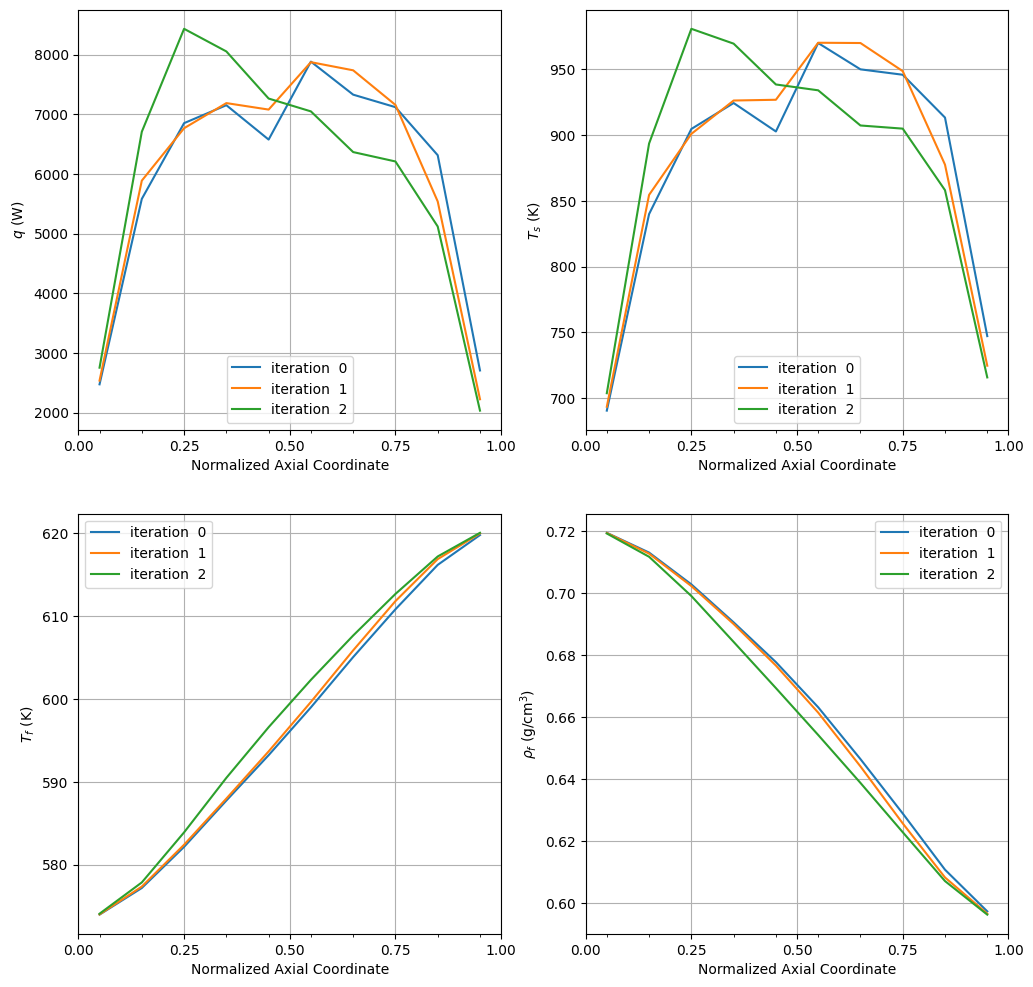

In [30]:
plt.show()